## Uniswap V3 Order Book

Here we utilize UniswapPy to simulate an order book in Uniswap V3

In [1]:
from uniswappy import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

user_nm = MockAddress().apply()
eth_amount = 100
tkn_amount = 1000

fee = UniV3Utils.FeeAmount.MEDIUM
tick_spacing = UniV3Utils.TICK_SPACINGS[fee]

#### Simulate prices
Simulate prices using a geometric brownian motion process

In [2]:
n_steps = 1000
start_price = eth_amount/tkn_amount
mu = 0.1; sigma = 0.5
n_paths = 1

b = BrownianModel(start_price)
p_arr = b.gen_gbms(mu, sigma, n_steps, n_paths)
exp_p_arr = np.median(p_arr, axis = 1)

accounts = MockAddress().apply(50)

#### Setup pool

In [3]:
eth = ERC20("ETH", "0x09")
tkn = ERC20("TKN", "0x111")

exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", 
                                   address="0x011", version = 'V3', 
                                   tick_spacing = tick_spacing, 
                                   fee = fee)

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

lwr_tick = UniV3Helper().get_price_tick(lp, -1, 10, 1000)
upr_tick = UniV3Helper().get_price_tick(lp, 1, 10, 1000)

Join().apply(lp, user_nm, eth_amount, tkn_amount, lwr_tick, upr_tick)
lp.summary()

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 96.70469739529014, TKN = 1000.0
Gross Liquidity: 6440.3320664241655 



#### Simulate liquidity pool

In [4]:
arb = CorrectReserves(lp, x0 = 1/exp_p_arr[0])
p_intervals = [500, 800, 1000, 1200, 1500, 1700, 2000]
lp_prices = [lp.get_price(tkn)]
lp_liquidity = [lp.total_supply]
lp_swaps = []; lp_net_deposits = [];

for k in range(1, n_steps):
    p = 1/exp_p_arr[k]
    arb.apply(p, lwr_tick, upr_tick)
    
    select_tkn = EventSelectionModel().bi_select(0.5)
    rnd_add_amt = TokenDeltaModel(25).delta()
    rnd_swap_amt = TokenDeltaModel(15).delta()
    user_add = random.choice(accounts)
    user_swap = random.choice(accounts)

    p_interval = random.choice(p_intervals)
    lwr_tick = UniV3Helper().get_price_tick(lp, -1, lp.get_price(eth), p_interval)
    upr_tick = UniV3Helper().get_price_tick(lp, 1, lp.get_price(eth), p_interval)
    
    if(select_tkn == 0): 
        AddLiquidity().apply(lp, eth, user_add, rnd_add_amt, lwr_tick, upr_tick)
        out = Swap().apply(lp, eth, user_swap, rnd_swap_amt) 
    else:
        AddLiquidity().apply(lp, tkn, user_add, p*rnd_add_amt, lwr_tick, upr_tick)
        out = Swap().apply(lp, tkn, user_swap,  p*rnd_swap_amt) 
        
    lp_prices.append(lp.get_price(tkn))
    lp_liquidity.append(lp.total_supply)
    lp_swaps.append(rnd_swap_amt)
    lp_net_deposits.append(rnd_add_amt)

lp.summary()

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 88042.25289117916, TKN = 652709.5179564967
Gross Liquidity: 3500419.6604869883 



#### Construct order book

In [5]:
liquidity = {}
df_liq = pd.DataFrame(columns=['tick', 'price', 'liquidity'])
for k, pos in enumerate(lp.ticks):
    price = UniV3Helper().tick_to_price(pos)
    liq = lp.ticks[pos].liquidityGross/10**18
    df_liq.loc[k] = [pos,price,liq]

center_pos = UniV3Helper().price_to_tick(lp.get_price(eth))
price = lp.get_price(tkn)
df_liq.loc[k+1] = [center_pos,price,0]

df_liq.sort_values(by=['price'], inplace=True)
df_liq.reset_index(drop=True, inplace=True)

side_arr = []
for tick in df_liq['tick'].values:
    if (tick > center_pos):
        side_arr.append('asks')
    elif (tick < center_pos):
        side_arr.append('bids')
    else:
        side_arr.append('center')
df_liq['side'] = side_arr
idx = df_liq.index[df_liq['side'] == 'center']
df_liq.drop(idx[0], inplace=True)

In [6]:
df_liq

,tick,price,liquidity,side
1,19020.0,6.698643,286.529325,bids
2,19200.0,6.820304,312.424075,bids
3,19320.0,6.902636,361.702555,bids
4,19380.0,6.944174,186.412605,bids
5,19440.0,6.985963,697.149675,bids
...,...,...,...,...
139,27600.0,15.797663,4887.963529,asks
140,27660.0,15.892729,3885.521549,asks
141,27780.0,16.084581,1193.063307,asks
142,27900.0,16.278749,826.819911,asks


#### Review simulation output

<Figure size 1000x500 with 0 Axes>

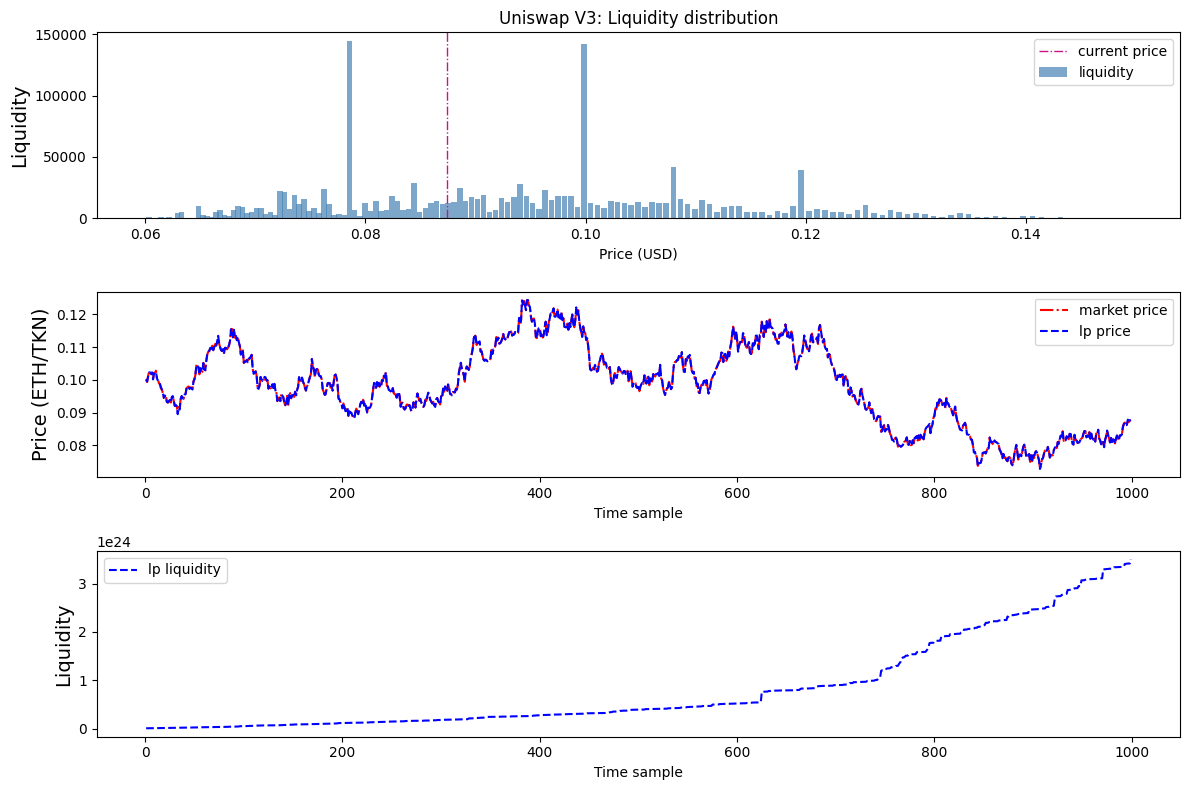

In [7]:
fig = plt.figure(figsize = (10, 5))

current_price = lp.get_price(tkn)
prices = 1/df_liq['price'].values
liquidity = df_liq['liquidity'].values

fig, (book_ax, price_ax, liq_ax) = plt.subplots(nrows=3, sharex=False, sharey=False, figsize=(12, 8))

book_ax.bar(prices, liquidity, color ='steelblue', width = 0.0005, label = 'liquidity', alpha=0.7)
book_ax.axvline(x=current_price, color = 'mediumvioletred', linewidth = 1, linestyle = 'dashdot', label = 'current price')
book_ax.set_xlabel("Price (USD)", size=10)
book_ax.set_ylabel("Liquidity", size=14)
book_ax.set_title("Uniswap V3: Liquidity distribution")
book_ax.legend()

x_val = np.arange(0,len(p_arr))
price_ax.plot(x_val[1:-1], p_arr[1:-1], color = 'r',linestyle = 'dashdot', label='market price') 
price_ax.plot(x_val[1:-1], lp_prices[1:], color = 'b',linestyle = 'dashed', label='lp price') 
price_ax.set_ylabel('Price (ETH/TKN)', size=14)
price_ax.set_xlabel('Time sample', size=10)
price_ax.legend()

liq_ax.plot(x_val[1:-1], lp_liquidity[1:], color = 'b',linestyle = 'dashed', label='lp liquidity') 
liq_ax.set_ylabel('Liquidity', size=14)
liq_ax.set_xlabel('Time sample', size=10)
liq_ax.legend()
plt.tight_layout()

Text(0, 0.5, 'Frequency')

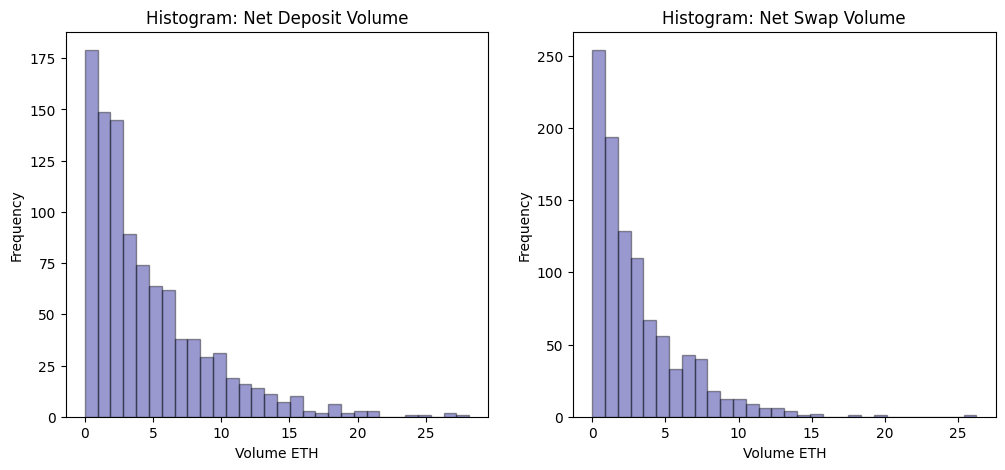

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.distplot(lp_net_deposits, hist=True, kde=False, bins=int(30), color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, ax=ax[0])

ax[0].set_title('Histogram: Net Deposit Volume')
ax[0].set_xlabel('Volume ETH')
ax[0].set_ylabel('Frequency')

sns.distplot(lp_swaps, hist=True, kde=False, bins=int(30), color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, ax=ax[1])

ax[1].set_title('Histogram: Net Swap Volume')
ax[1].set_xlabel('Volume ETH')
ax[1].set_ylabel('Frequency')

#### Plot order book

Text(0, 0.5, 'Liquidity')

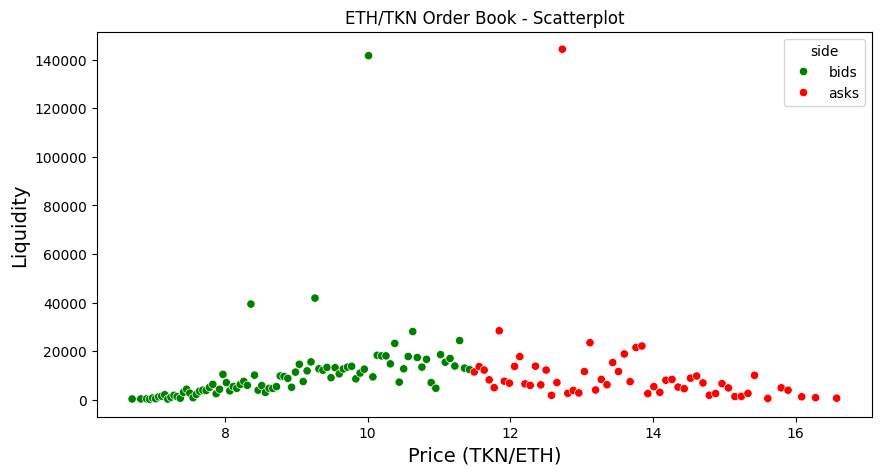

In [9]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.set_title(f"ETH/TKN Order Book - Scatterplot")
sns.scatterplot(x="price", y="liquidity", hue="side", 
                data=df_liq, ax=ax, palette=["green", "red"])
ax.set_xlabel("Price (TKN/ETH)", fontsize = 14)
ax.set_ylabel("Liquidity", fontsize = 14)

Text(0, 0.5, 'Liquidity')

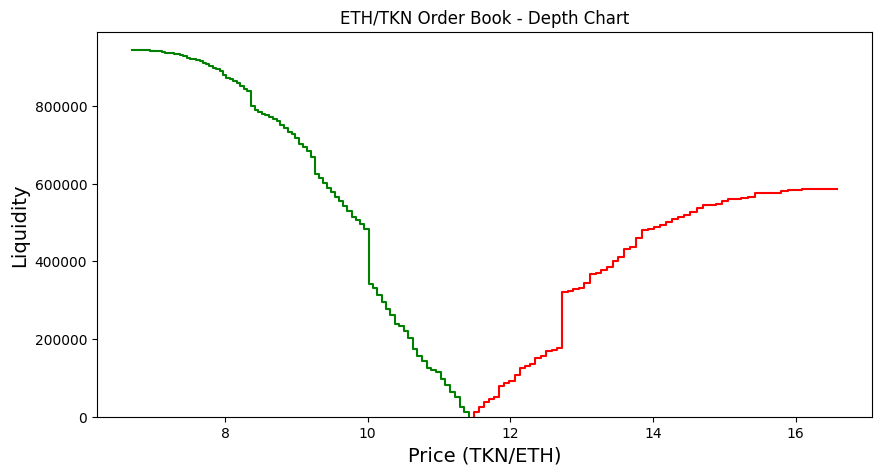

In [10]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.set_title(f"ETH/TKN Order Book - Depth Chart")
sns.ecdfplot(x="price", weights="liquidity", stat="count", 
             complementary=True, data=df_liq.query("side == 'bids'"), 
             color="green", ax=ax)
sns.ecdfplot(x="price", weights="liquidity", stat="count", 
             data=df_liq.query("side == 'asks'"), color="red", 
             ax=ax)
ax.set_xlabel("Price (TKN/ETH)", fontsize = 14)
ax.set_ylabel("Liquidity", fontsize = 14)